<div style="width: 80%;">

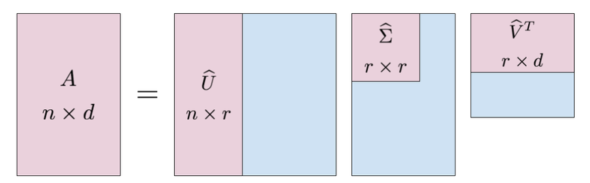
<div style="clear: both"></div>
<br>

<div style="font-size: 20pt; float: left;">Anwendungen der linearen Algebra</div>
<div style="font-size: 20pt; text-align: right;">FS 2024</div>
<div style="font-size: 15pt; margin-top: 10px;">Fachexperten: Roger Burkhardt, Cédric Huwyler</div>
</div>
<br>


# Mini-Challenge 3 zum Thema *Recommender-Systeme*

In der dritten Mini-Challenge befassen wir uns mit einem einfachen Recommender-System, mit dem du dir zu einem Film weitere ähnliche Filme vorschlagen lassen kannst. Sicher hattest du auch schon Abende, wo du Lust hattest einen Film zu schauen, aber keine konkrete Idee hattest. In dieser Minichallenge möchten wir dir dazu mit linearer Algebra etwas Abhilfe schaffen!

Als Datenbasis benutzen wir den [kleinen *Movie Lens*-Datensatz](https://grouplens.org/datasets/movielens/) mit nur 610 Nutzer:innen und 9742 Filmen. Er ist das Ergebnis des [Movie Lens](https://movielens.org/)-Projekts, das seit 1997 Film-Bewertungen sammelt. Für die Erstellung von Empfehlung arbeiten wir mit dem einfachen Cosine Similarity-basierten IBCF-Recommender aus dem Skript.

Eine kleine Webapplikation, die auf dem Code dieser Minichallenge basiert, findest du auf

http://simplemovierecommender.pythonanywhere.com/

So musst du nicht immer ein Notebook starten, wenn du eine neue Recommendation brauchst.

### Musterlösung

Zu dieser Minichallenge existiert (bewusst) keine Musterlösung. Du kannst sie aber gerne zur Durchsicht und Kommentierung uns entweder in einer der Kontaktstunden vorstellen oder zuschicken (cedric.huwyler@fhnw.ch).

### Libraries

Es reicht in dieser Übung aus, die folgenden Python-Libraries zu benutzen:

**Hinweis:** Allenfalls musst du das tqdm-Paket noch installieren.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Interaktionsmatrix bestimmen

Die Basis von kollaborationsbasierten Systemen ist die sogenannte **Interaktions-** oder **User-Item-Matrix**. Sie enthält in den Zeilen die Nutzer:innen des Systems, in den Spalten die Items (oft die Produkte, in unserem Fall die Filme) und als Matrixelemente jeweils die Bewertung, die Nutzer:in $i$ für Produkt $j$ abgegeben hat. Hier eine beispielhafte Illustration für Filme:

<center>
<img src="mc3_interaktionsmatrix.png" width="300">
</center>

6 Nutzer:innen haben ingesamt 19 Bewertungen für 6 Filme abgegeben. Niemand hat alle Filme bewertet, nur etwa die Hälfte aller möglichen Bewertungen sind vorhanden. Die Interaktionsmatrix ist die Wissensbasis des Recommender-Systems, das wir bauen möchten.

Wir möchten nun im Folgenden gerne diese Interaktionsmatrix erstellen, damit wir von ihr ausgehend weiterrechnen können. Wir erstellen sie aus den beiden Dateien `movies.csv` und `ratings.csv`, die der Minichallenge beiliegen. Das dazu nötige Data Wrangling soll hier nicht im Fokus stehen, daher ist es bereits für dich erledigt:

Daten einlesen:

In [ ]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

Bereinigungen durchführen:

In [ ]:
movies['year'] = movies.title.str.extract("\((\d+)\)$").astype(float)
movies.title = movies.title.str.replace("\(\d+\)", "", regex=True)
movies.title = movies.title.str.replace(r'(.+), The', r'The \1', regex=True)
movies.title = movies.title.str.replace(r'(.+), A', r' \1', regex=True)
movies.title = movies.title.str.strip()
movies.head()

Filme ohne Rating entfernen:

In [ ]:
movies = movies[movies.movieId.isin( ratings.movieId.unique() )].reset_index( drop=True )
movies.shape

Interaktionsmatrix erstellen:

In [ ]:
I = pd.crosstab( ratings.userId, ratings.movieId, values=ratings.rating, aggfunc='mean', dropna=True ).fillna(0)
user_ids = I.index
movie_ids = I.columns
X = I.values

Belegung der Interaktionsmatrix:

In [ ]:
np.mean( X>0 )

Nur 1.7% aller möglichen Bewertungen liegen vor!

Shape der Interaktionsmatrix:

In [ ]:
X.shape, len(user_ids), len(movie_ids)

Visualisierung der Belegung der Interaktionsmatrix:

In [ ]:
plt.matshow(X > 0, cmap="gray")

## Empfehlungen erstellen (deine Aufgabe)

Nun bist du dran! Du sollst die Ähnlichkeiten zwischen den verschiedenen Filmen mit der Cosine Similarity bestimmen und diese zur Erstellung von Empfehlungen benutzen. Wir gehen dabei Stück für Stück vor und berechnen zuerst eine einzelne Cosine Similarity, dann die ganze Ähnlichkeitsmatrix und erstellen schliesslich Filmempfehlungen daraus.

### a) Einzelne Cosine Similarity berechnen

Gegeben sei also die Interaktionsmatrix $X\in \mathbb{R}^{610 \times 9724}$. Die Cosine Similarity zwischen Film $i$ und Film $j$ ist definiert als

$$s_{ij} = \frac{\mathbf{x}_i \cdot \mathbf{x}_j}{|\mathbf{x}_i| \; |\mathbf{x}_j|},$$

wobei $\mathbf{x}_i$ den i-ten Spaltenvektor von $X$ bezeichne. 

Berechne als Beispiel die Cosine Similarity zwischen den Filmen 'Star Wars: Episode IV - A New Hope' ($i=224$) und 'Star Wars: Episode V - The Empire Strikes Back' ($j=897$). Benutze dazu die Befehle `np.dot()` und `np.linalg.norm()`. Definiere zuerst die Spaltenvektoren `xi` und `xj` mit geeignetem Slicing von $X$ und prüfe, ob diese jeweils 610 Elemente enthalten (eine Bewertung pro Benutzer:in). Sind die Filme einander gemäss diesem Mass ähnlich?

In [ ]:
# DEIN CODE

### b) Ähnlichkeitsmatrix $S$ mit for-Schleife berechnen

Für unser Recommender-System möchten wir gerne auf Vorrat $s_{ij}$ für alle Benutzer:innen $i$ und Filme $j$ berechnen, damit wir nachher schnell für alle Filme Empfehlungen berechnen können. Damit erhalten wir die **Ähnlichkeitsmatrix** $S \in \mathbb{R}^{9724 \times 9724}$, deren Elemente gerade die $s_{ij}$ für alle möglichen Filmpaare sind.

Wir haben in a) ein einzelnes Element $s_{ij}$ der Matrix $S$ berechnet. Um die ganze Ähnlichkeitsmatrix zu berechnen, können wir mit einer verschachtelten for-Schleife über alle $i$ und $j$ iterieren und die einzelnen Elemente von $S$ befüllen. Es wird sich zeigen, dass dieser Ansatz sehr ineffizient ist und etwas länger dauert (5-10 Minuten), darum macht es Sinn, das tqdm-Paket zu verwenden, das dir neben einer Fortschrittsanzeige auch eine ungefähre Abschätzung der noch zu erwartenden Berechnungszeit anzeigt.

Das tqdm-Paket kann sehr einfach verwendet werden:

Umschliesse einfach das *Iterable*, über das du mit deiner for-Schleife iterieren möchtest, mit der `tqdm()`-Funktion. Diese liefert dann ein neues Iterable zurück und übernimmt die Progressbar für dich. Zum Beispiel wird so `for i in range(1000)` zu `for j in tqdm(range(1000))`. Hier gleich zum Ausprobieren:

In [ ]:
for i in tqdm( range(1000) ):
    i**50000 # gibt nichts aus - nur zum Verlangsamen der Schleife

Berechne nun die gesamte Matrix $S$ mit einer verschachtelten for-Schleife über $i$ und $j$ und setze um die äussere `range()`-Funktion ein `tqdm()`. Wie lange musst du rechnen?

In [ ]:
# DEIN CODE

### c) Cosine-Similarity vektorisiert berechnen

Wie wir in Teilaufgabe b) gesehen haben, ist die Berechnung aller ca. 95 Millionen Matrixelemente der Ähnlichkeitsmatrix $S$ über verschachtelte for-Schleifen etwas zeitaufwändig. Das ist aus zwei Gründen so:

1. Python ist eine Interpretersprache und for-Schleifen sind dort sehr viel langsamer als in einer kompilierten Sprache. 
2. Da alles sequentiell abgearbeitet wird, können die Möglichkeiten der *Vektorisierung* auf deinem Prozessor nicht ausgenutzt werden, bei der parallel mehrere Berechnungen durchgeführt werden.

Typischerweise brauchen verschachtelte for-Loops so schnell 100 mal länger, es empfiehlt sich also, möglichst auf diese zu verzichten und stattdessen mit Vektoren und Matrizen zu arbeiten. Die Numpy-Bibliothek ist in C kompiliert und dementsprechend effizient.

Im Skript hast du gesehen, dass die Ähnlichkeitsmatrix aus der Interaktionsmatrix als 

$$
S = X^T X
$$

berechnet werden kann, wenn alle Spalten der Interaktionsmatrix $X$ vorgängig auf den Betrag 1 normiert wurden.

Berechne nun $S$ auf diese Weise. Normiere zuerst die Spalten von $X$ auf 1, indem du jede Spalte geeignet durch ihre Länge dividierst (Stichwort [Broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)) und berechne dann $S$ gemäss obiger Formel. Prüfe, ob $S$ die richtigen Dimensionen hat, ob alle Elemente von $S$ zwischen 0 und 1 liegen und ob alle Diagonalelemente von $S$ gleich 1 sind. Du wirst merken, dass die Berechnung auf diese Art wesentlich schneller geht. Wenn du Lust hast, kannst du mit `%%timeit` prüfen, wieviel schneller!

In [ ]:
# DEIN CODE

### d) Ähnliche Filme finden

In dieser Aufgabe kannst du nun die aus deinen Berechnungen resultierenden Empfehlungen für deine Lieblingsfilme ausprobieren. Praktisch die ganze Arbeit ist dabei für dich schon erledigt. Finde dazu zuerst die `movieId` eines ausgewählten Films, indem du wie im untenstehenden Beispiel nach dem Titel des Films suchst:

In [ ]:
movies[movies.title.str.contains("Hackers", case=False)]

Ausserdem setzen wir die Ähnlichkeit aller Filme mit sich selbst auf Null, damit ein Film nicht sich selbst vorgeschlagen wird:

In [ ]:
d = np.arange(S.shape[0])
S[d,d] = 0

Du kannst nun die folgende Funktion für eine Recommendation aufgrund deiner Ähnlichkeitsmatrix verwenden (und optional verstehen):

In [ ]:
def recommend( movieId, S, sim_thresh=0.3, n_max=20 ):
    i = np.where( movie_ids == movieId )[0][0]
    rec = pd.DataFrame( {
        'movieId': movie_ids[np.argsort( S[i,:] )][::-1], 
        'similarity': np.sort(S[i,:])[::-1] 
    } )
    rec = rec[rec.similarity>=sim_thresh]
    rec = rec.merge(movies, on="movieId")
    return rec.head(n_max)

Im Prinzip sucht diese Funktion zum gegebenen Film die Filme mit der höchsten Ähnlichkeit. Hat der Film den Index $i$ in der Matrix $S$, so suchen wir also die $j$, für die $s_{ij}$ nahe bei 1 ist. Der ganze Vorgang ist etwas komplizierter, weil nicht alle Filme bewertet sind und daher das Feld `movieId` generell nicht mit dem entsprechenden Index in der Matrix $S$ übereinstimmt.

In [ ]:
recommend( movieId=170, S=S ).head(20)

## Ausblick

Damit hast du nun ein sehr einfaches Recommender-System verstanden und implementiert! Die Empfehlungen scheinen vernünftig, sind aber auch oft nicht die besten. Zum Beispiel hat dieses System einen starken sogenannten *Popularity-Bias* für Filme, die sehr häufig gerated wurden. Ebenfalls sind in den Präferenzen der Nutzer:innen oft nebst Filmgeschmack auch die Zeitepochen abgebildet, in denen sie eher jung waren und Zeit für Filme hatten. So erhält man für Filme aus den 90ern halt öfters auch Filme aus den 90ern empfohlen. In der Realität werden daher oft auch komplexere Methoden eingesetzt, die zusätzlich noch auf Eigenschaften der Filme wie Genre, Veröffentlichungsdatum usw. zurückgreifen. Lust auf mehr? Unbedingt die Kompetenz [Recommender Systeme](https://spaces.technik.fhnw.ch/spaces/recommender-systems) besuchen!